# 영화 리뷰를 사용한 텍스트 분류

- 영화 리뷰들은 영문!
- 영화 리뷰를 분석하여 긍정 평가와 부정 평가를 분류
- 이진 분류의 문제
- 인터넷 영화 데이터베이스에서 수집한 50,000개의 영화 리뷰를 담고있는 IMDB 데이터 세트을 사용
- 훈련 세트 25,000개, 테스트 세트 25,000개이며 훈련 세트와 데이터 세트의 긍정과 부정 평가의 개수는 동일하다.

### 중요 모듈 import

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.7.0


### IMDB 데이터 세트 다운로드
- 리뷰는 미리 전처리하여 정수 시퀀스로 변환되어 있음
- 각 정수는 어휘 사전에 있는 특정 단어를 의미함
- num_words=10000은 훈련 데이터에서 가장 많이 등장하는 상위 10,000개의 단어를 선택하도록 함

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 0s 0us/step


### 데이터 탐색
- 데이터 세트의 레이블은 0 또는 1
- 0은 부정 평가, 1은 긍정 평가

In [3]:
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플: 25000, 레이블: 25000


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


- 영화 리뷰들은 모두 길이가 다름
- 신경망에서는 입력의 길이가 모두 같아야 하므로 나중에 길이에 대한 문제 처리

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

#### 정수를 단어로 다시 변환하기

In [6]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
# index 공간을 추가하여 
word_index = {k:(v+3) for k,v in word_index.items()}
# 4개의 특수한 문자열을 추가한다.
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

# 단어가 key, 정수가 값으로 되어 있던 것을 정수가 key, 단어가 값이 되도록 바꾼다.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1654784/1641221 [==============================] - 0s 0us/step


In [13]:
len(word_index)

88588

In [26]:
reverse_word_index[0]

'<PAD>'

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 데이터 준비

- 리뷰(정수 배열)는 신경망에 주입되기 전에 텐서로 변환되어야 한다. 변환 방법은
    - one-hot encoding: 해당하는 값은 1로 나머지 값들은 모두 0으로 체운 벡터 생성, 메모리를 많이 차지함
    - 정수 배열의 길이가 모두 같도록 패딩을 추가해 max_length * num_reviews 크기의 정수 텐서를 만든다.
- 여기서는 두 번째 방법을 사용

In [16]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',    # 패딩 값을 뒤쪽에 붙임, 앞쪽에 붙이는 경우에는 'pre' 사용
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

- 변환된 길이 확인: 256으로 길이가 같아짐
- 길이가 256보다 짧은 리뷰들은 빈 공간에 0으로 패딩 

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### 모델 구성

- 두 가지 참고해야 할 사항
    - 모델에서 얼마나 많은 층을 사용할 것인가?
    - 각 층에서 얼마나 많은 은닉 유닛을 사용할 것인가?

In [11]:
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다(10,000개의 단어)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

2022-01-27 15:13:27.194661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-27 15:13:27.195448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


- 각 층에 대한 설명
    - Embbeding: 
        - 모델의 첫 번째 레이어로만 사용 가능
        - 정수로 인코딩된 배열을 입력받아 각 단어 인덱스에 해당하는 임베딩 벡터를 찾는다. 
        - 모델이 훈련되면서 학습한다. 
        - 출력 배열에 새로운 차원으로 추가된다.
        - 최종 출력값의 차원은 (batch, sequence, embedding)이다(25000, 256, 16).
    - GlobalAveragePooling1D:
        - sequence 차원에 대한 평균을 계산하여 각 샘플에 대한 고정된 길이의 출력 벡터를 반환한다.
        - 길이가 다른 입력을 다루는 가장 간단한 방법
    - Dense 1:
        - 16개의 유닛을 가진 완전 연결 층
        - 활성화 함수로 relu 사용
    - Dense 2:
        - 하나의 최종 출력을 갖는 완전 연결 층
        - 활성화 함수로 sigmoid 함수를 사용하여 0\~1 사이의 실수값을 출력한다.
        - 이 출력 값은 확률 또는 신뢰도이다.
        
#### 은닉 유닛
- 두 개의 은닉 층이 존재(GlobalAveragePooling1D와 첫 번째 Dense)
- 출력(유닛, 노드, 뉴런...)의 개수는 층이 가진 표현 공간의 차원
- 모델에 많은 은닉 유닛과 층이 있다면 더 복잡한 표현을 학습할 수 있지만 과대적합에 빠지기 쉽다.

#### 손실 함수와 옵티마이저
- 이진 분류 모델이므로(최종 출력층에서 출력 유닛이 1개이고 활성화 함수가 sigmoid임) binary_crossentropy 손실 함수를 사용
- 다른 손실 함수도 사용 가능하나 확률을 다루는데는 binary_crossentropy가 적합함
- 정답인 타깃 분포와 예측 분포 사이의 거리 

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 검증 세트 만들기
- 훈련 세트에서 10,000개를 나누어 검증 세트로 사용

In [18]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 모델 훈련
- 512 개의 샘플로 이루어진 미니 배치에서 40 에포크(epoch) 동안 훈련
- 훈련하는 동안 위에서 만든 10,000 개의 검증 데이터 세트로 모니터링 수행

In [19]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

2022-01-27 16:26:10.669256: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40


2022-01-27 16:26:10.928534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 7s 177ms/step - loss: 0.6913 - accuracy: 0.5999 - val_loss: 0.6889 - val_accuracy: 0.7090
Epoch 2/40


2022-01-27 16:26:17.492867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 5s 175ms/step - loss: 0.6847 - accuracy: 0.6822 - val_loss: 0.6801 - val_accuracy: 0.7376
Epoch 3/40
30/30 [==============================] - 5s 178ms/step - loss: 0.6710 - accuracy: 0.7535 - val_loss: 0.6630 - val_accuracy: 0.7535
Epoch 4/40
30/30 [==============================] - 5s 173ms/step - loss: 0.6470 - accuracy: 0.7719 - val_loss: 0.6358 - val_accuracy: 0.7690
Epoch 5/40
30/30 [==============================] - 5s 173ms/step - loss: 0.6116 - accuracy: 0.7915 - val_loss: 0.5984 - val_accuracy: 0.7813
Epoch 6/40
30/30 [==============================] - 5s 173ms/step - loss: 0.5671 - accuracy: 0.8062 - val_loss: 0.5555 - val_accuracy: 0.8003
Epoch 7/40
30/30 [==============================] - 5s 176ms/step - loss: 0.5183 - accuracy: 0.8269 - val_loss: 0.5111 - val_accuracy: 0.8167
Epoch 8/40
30/30 [==============================] - 5s 170ms/step - loss: 0.4700 - accuracy: 0.8453 - val_loss: 0.4689 - val_accuracy: 0.8323
Epoch 9/40
30/30 

### 모델 평가

In [20]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 2s - loss: 0.3435 - accuracy: 0.8713 - 2s/epoch - 2ms/step
[0.3435123562812805, 0.8713200688362122]


### 정확도와 손실 그래프 그리기
- model.fit()은 History 객체를 반환

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

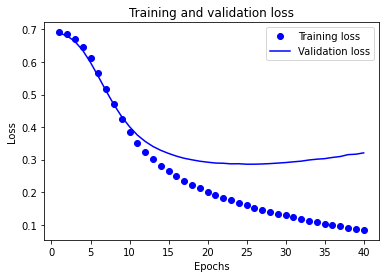

In [22]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

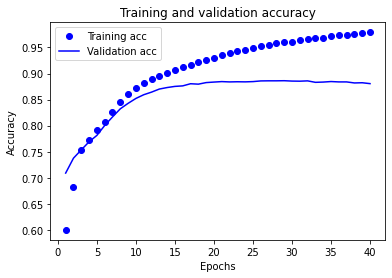

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

> 테스트 시에는 손실은 지속적으로 감소하고 훈련 정화도는 지속적으로 증가하고 있다.  
> 하지만 검증의 경우 손실은 20 에포크, 정확도는 15 에포크 언저리에서 변화가 없다.  
> 검증 데이터에서 성능이 좋지 않으므로 과대적합 되어 있다고 볼 수 있다.  
> 이런 경우 과대 적합을 막기 위해 20 에포크 언저리에서 훈련을 멈추는 방법이 있다.  